# The London Railway Network

The cell below defines the abstract class whose API you will need to impement. Do NOT modify it.

In [102]:
# DO NOT MODIFY THIS CELL

from abc import ABC, abstractmethod  

class AbstractLondonRailwayMapper(ABC):
    
    # constructor
    @abstractmethod
    def __init__(self):
        pass           
        
    # data initialisation
    @abstractmethod
    def loadStationsAndLines(self):
        pass

    # returns the minimum number of stops to connect station "fromS" to station  "toS"
    # fromS : str
    # toS : str
    # numStops : int
    @abstractmethod
    def minStops(self, fromS, toS):     
        numStops = -1
        return numStops    
    
    # returns the minimum distance in miles to connect station "fromS" to station  "toS"
    # fromS : str
    # toS : str
    # minDistance : float
    @abstractmethod
    def minDistance(self, fromS, toS):
        minDistance = -1.0
        return minDistance
    
    # given an unordered list of station names, returns a new railway line 
    # (represented as a list of adjacent station names), connecting all such stations 
    # and such that the sum of the distances (in miles) between adjacent stations is minimised
    # inputList : set<str>
    # outputList : list<str>
    @abstractmethod
    def newRailwayLine(self, inputList):
        outputList = []
        return outputList

Use the cell below to define any data structure and auxiliary python function you may need. Leave the implementation of the main API to the next code cell instead.

In [103]:
# ADD YOUR DATA STRUCTURE DEFINITIONS AND HELPER CODE HERE

from math import sqrt,cos, sin, radians, sqrt, atan2, pi
from matplotlib import pyplot as plt

def euclidean_distance(lat1, lng1, lat2, lng2):
    return sqrt((lat1-lat2) ** 2 + (lng1-lng2) ** 2)


def harvensineDistance(lat1, lng1, lat2, lng2):
    earthRadius = 3958.7613322984894 # earth's radius in miles
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    lng2 = radians(lng2)
    lng1 = radians(lng1)

    dLat = lat2-lat1;
    dLng = lng2-lng1;
    a = sin(dLat/2) * sin(dLat/2) + cos(lat1) * cos(lat2) * sin(dLng/2) * sin(dLng/2);
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return earthRadius * c

class PQ:

    def __init__(self):
        self.values = []
    
    def insert(self, value):
        self.values.append(value)
        self.__swim_up(len(self.values) - 1)

    def delMin(self):

        if len(self.values) == 0: 
            return None

        # swap the first and last element of the values
        self.__swap(0, len(self.values) - 1)
        output = self.values.pop()
        self.__sink(0)
        return output

    def size(self):
        return len(self.values)
    
    def contains(self, targetValue):
        for value in self.values:
            if value == targetValue:
                return True
        return False

    def isEmpty(self):
        return self.size() == 0


    def __sink(self, targetIndex):
        
        queueSize = len(self.values)


        while True:
            leftIndex = 2 * targetIndex + 1
            rightIndex = 2 * targetIndex + 2

            smaller = leftIndex

            if rightIndex < queueSize and self.values[rightIndex] < self.values[smaller]:
                smaller = rightIndex
            
            # needs to be >= here because the case of just two values
            if leftIndex >= queueSize or self.values[smaller] > self.values[targetIndex]:
                break

            self.__swap(smaller, targetIndex)
            targetIndex = smaller

    def decreaseKey(self, targetValue, priority):
            index = 0
            for value in self.values:
                if value == targetValue:
                    value.priority = priority
                    self.__swim_up(index)
                    # self.__sink(index)
                index += 1


    def __swim_up(self, targetIndex):
        parent_index = (targetIndex - 1) // 2

        while self.values[targetIndex] < self.values[parent_index] and targetIndex > 0:

            self.__swap(parent_index, targetIndex)

            targetIndex = parent_index
            parent_index = (targetIndex - 1) // 2


    def __swap(self, firstIndex, secondIndex):
        tmp = self.values[firstIndex]
        self.values[firstIndex] = self.values[secondIndex]
        self.values[secondIndex] = tmp



class PQItem:
    def __init__(self, name, priority):
        self.name = name
        self.priority = priority
    
    def __eq__(self, name):
        return self.name == name
    
    def __ge__(self, other):
        return self.priority >= other.priority

    def __gt__(self, other):
        return self.priority > other.priority
    
    def __le__(self, other):
        return self.priority <= other.priority
    
    def __lt__(self, other):
        return self.priority < other.priority

class Graph:

    def __init__(self, V):
        self.V = V
        self.adj = []
        for _ in range (0, V):
            self.adj.append([])

    def addEdge(self, e):
        v = e.endPoint()
        w = e.otherEndPoint(v)
        self.adj[v].append(e)
        # self.adj[w].append(e)
        # we have to swap here because we have to relax its outgoing edges, if we don't swap the direction around it would relax the wrong end
        self.adj[w].append(e.swap())
        # print(self.adj)

    def adjacencies(self, v):
        return self.adj[v]


class TSPGraph(Graph):

    def __init__(self, V, stations):
        super().__init__(V)
        self.stations = []
        self.minEdges = PQ()
        self.__createCompleteGraph(stations)

    def getStationName(self, index):
        return self.stations[index].getName()
    
    def getStations(self):
        return self.stations.copy()

    def getStation(self, index):
        return self.stations[index]

    def __createCompleteGraph(self, inputStations):
        for index, currentStation in enumerate(inputStations):
            for createdStationIndex, createdStation in enumerate(self.stations):
                distance = euclidean_distance(self.stations[createdStationIndex].lat, self.stations[createdStationIndex].lng, currentStation.lat, currentStation.lng)
                edge = Edge(index, createdStationIndex, distance)
                self.addEdge(edge)
                self.minEdges.insert(edge)
            self.stations.append(currentStation)



class Edge:
    def __init__(self, v, w, weight):
        self.v = v
        self.w = w
        self.weight = weight

    def endPoint(self):
        return self.v

    def otherEndPoint(self, vertex):
        if vertex == self.v:
            return self.w
        return self.v

    def same(self, e):
        return self.v == e.endPoint() and self.w == e.otherEndPoint(e.endPoint()) and self.weight == e.getWeight()

    def getWeight(self):
        return self.weight

    def swap(self):
        return Edge(self.w, self.v, self.weight)
    
    def __str__(self):
        return f"v: {self.v}, w: {self.w}, weight: {self.weight}"
    
    def __eq__(self, other):
        return self.weight == other.weight
    
    def __ge__(self, other):
        return self.weight >= other.weight

    def __gt__(self, other):
        return self.weight > other.weight
    
    def __le__(self, other):
        return self.weight <= other.weight
    
    def __lt__(self, other):
        return self.weight < other.weight
    

    
class Queue():
    def __init__(self):
        self.queue = []
    
    def isEmpty(self):
        return self.queue == []
    
    def enqueue(self, item):
        self.queue.append(item)
    
    def dequeue(self):
        return self.queue.pop(0)
    
    def size(self):
        return len(self.queue)
    


class BFS:
    def __init__(self, G, s):
        self.starting = s
        self.distToSource = [-1 for v in range(0, G.V)]
        self.edgeTo = [-1 for v in range(0, G.V)]
        self.__bfs(G, s)

    def __bfs(self, G, s):
        q = Queue()
        q.enqueue(s)
        self.distToSource[s] = 0
        while(not q.isEmpty()):
            v = q.dequeue()

            for w in G.adjacencies(v):
                index = w.otherEndPoint(v)
                if (self.distToSource[index] == -1):
                    q.enqueue(index)
                    self.distToSource[index] = self.distToSource[v] + 1
                    self.edgeTo[index] = v
    
    def hasPathTo(self, v):
        return self.distToSource[v] != -1
    

    ## BFS calculates shortest path so this is the shortest path
    def pathTo(self, v):
        if (not self.hasPathTo(v)): return None

        path = []
        x = v
        while (x != self.starting):
            path.append(x)
            x = self.edgeTo[x]
        path.append(self.starting)
        return path


    ## BFS calculates shortest path so this is the shortest length
    def lengthTo(self, v):
        if (not self.hasPathTo(v)): return None

        return self.distToSource[v] 

    
class DFS:
    path = []
    x = []
    y = []
    def __init__(self, G, s, names):
        self.names = names
        self.starting = s
        self.marked = [False for v in range(0, G.V)]
        self.edgeTo = [-1 for v in range (0, G.V)]
        self.path.append(self.names[s].getName())
        self.x.append(self.names[s].lat)
        self.y.append(self.names[s].lng)
        self.__dfs(G,s)
    
    def __dfs(self, G, v):
        self.marked[v] = True
        for w in G.adjacencies(v):
            currentPoint = w.otherEndPoint(w.endPoint())
            if (not self.marked[currentPoint]):
                self.path.append(self.names[currentPoint].getName())
                self.x.append(self.names[currentPoint].lat)
                self.y.append(self.names[currentPoint].lng)
                self.__dfs(G,currentPoint)
                self.edgeTo[currentPoint] = v
    
    def hasPathTo(self, v):
        return self.marked[v]

    # build the path backwards 
    def pathTo(self, v):
        if (not self.hasPathTo(v)): return None
        path = []
        x = v
        while (x != self.starting):
            path.append(x)
            x = self.edgeTo[x]
        path.append(self.starting)
        return path   
    

    
class LazyPrimMST:
    def __init__(self, G):
        self.marked = [False for v in range(0, G.V)]
        self.mst = Queue()
        self.pq = PQ()
        self.__visit(G, 0)
        
        limit = G.V - 1
        while (not self.pq.isEmpty() and self.mst.size() < limit):
            e = self.pq.delMin()
            v = e.endPoint()
            w = e.otherEndPoint(v)

            if self.marked[v] and self.marked[w]:
                continue
            self.mst.enqueue(e)

            if not self.marked[v]:
                self.__visit(G, v)
            
            if not self.marked[w]:
                self.__visit(G, w)
    
    def __visit(self, G, v):
        self.marked[v] = True

        for e in G.adjacencies(v):
            if not self.marked[e.otherEndPoint(v)]:
                self.pq.insert(e)

    
class Dijkstra:

    def __init__(self, G, s):
        self.edgeTo = [None for v in range (0, G.V)]
        # -1 for infinity since weight cannot be negative
        self.distTo = [-1 for v in range(0, G.V)]
        self.distTo[s] = 0


        self.pq = PQ()
        self.pq.insert(PQItem(s, 0))
        self.starting = s

        while not self.pq.isEmpty():
            v = self.pq.delMin().name
            for e in G.adjacencies(v):
                self.__relax(e)

    def __relax(self, e):
        v = e.endPoint()
        w = e.otherEndPoint(v)
        # print(w)
        if self.distTo[w] > self.distTo[v] + e.getWeight() or self.distTo[w] == -1:
            self.distTo[w] = self.distTo[v] + e.getWeight()
            self.edgeTo[w] = e

            if self.pq.contains(w):
                self.pq.decreaseKey(w, self.distTo[w])
                # print("will decrease key")
            else:
                self.pq.insert(PQItem(w, self.distTo[w]))



    # def hasPathTo(self, v):
    #     return self.distToSource[v] != -1
    

    def pathTo(self, v):
        path = []
        x = v
        while (x != self.starting):
            path.append(x)
            x = self.edgeTo[x].endPoint()
        path.append(self.starting)
        return path

    def lengthTo(self, v):
        return self.distTo[v] 
    
    
    
class TwoApprox:

    def __init__(self, G):
        print(G)
        mst = LazyPrimMST(G)
        dfsGraph = Graph(G.V)

        for edge in mst.mst.queue:
            print(edge)
            dfsGraph.addEdge(edge)

        result = DFS(dfsGraph, 0, G.getStations())
        self.result = result
    
    def getPath(self):
        return self.result.path, self.result.x, self.result.y

class BruteForce:

    def __init__(self, G):
        self.bestScore = -1
        self.bestPath = []
        self.G = G
        self.x = []
        self.y = []

        vertices = [x for x in range(G.V)]

        self.__permutations(len(vertices), vertices)

    def __tryPathAndScore(self, pathRoute):
        path = []
        x = []
        y = []
        score = 0

        previous_position = None
        for index, vertex in enumerate(pathRoute):
            currentStation = self.G.getStation(vertex)
            path.append(currentStation.getName())
            x.append(currentStation.lat)
            y.append(currentStation.lng)
            if (index == 0):
                previous_position = (currentStation.lat, currentStation.lng)
                continue
            
            score += euclidean_distance(previous_position[0], previous_position[1], currentStation.lat, currentStation.lng)

            previous_position = (currentStation.lat, currentStation.lng)
        
        if score < self.bestScore or self.bestScore == -1:
            self.bestPath = path
            self.bestScore = score
            self.x = x
            self.y = y


    def __permutations(self, size, values):
        if size == 1:
            self.__tryPathAndScore(values)
        else:

            self.__permutations(size - 1, values)

            for i in range(size - 1):
                if size % 2 == 0:
                    values[i], values[size - 1] = values[size - 1], values[i]
                else:
                    values[0], values[size - 1] = values[size - 1], values[0]
                
                self.__permutations(size - 1, values)
    
    
class StationInfo:

    def __init__(self, station_id, name, lat, lng):
        self.station_id = station_id
        self.name = name
        self.lat = float(lat)
        self.lng = float(lng)
    
    def getName(self):
        return self.name

    def __str__(self):
        return f"station_id: {self.station_id}, latitude: {self.lat}, longitude: {self.lng}"
    


In [104]:
class NearestNeighbor:
    def __init__(self, G):
        self.bestScore = -1
        self.bestPaths = []

        for starting in range(G.V):
            self.marked = [False for _ in range(G.V)]
            self.marked[starting] = True
            self.__nearestNeighbor(starting, G, G.getStation(starting).lat, G.getStation(starting).lng)
            print("\n\n")

    def __nearestNeighbor(self, v, G, startLat, startLng):
        vertexAmount = 0
        path = [G.getStationName(v)]
        score = 0
        x = [startLat]
        y = [startLng]
        currentVertex = v
        nextEdge = None
        while vertexAmount < G.V - 1:
            pq = PQ()
            for edge in G.adjacencies(currentVertex):
                pq.insert(edge)
            while not pq.isEmpty() and vertexAmount < G.V:
                nextEdge = pq.delMin()

                if self.marked[nextEdge.otherEndPoint(nextEdge.endPoint())]:
                    continue
                else:
                    break
            
            x.append(G.getStation(nextEdge.otherEndPoint(nextEdge.endPoint())).lat)
            y.append(G.getStation(nextEdge.otherEndPoint(nextEdge.endPoint())).lng)

            path.append(G.getStationName(nextEdge.otherEndPoint(nextEdge.endPoint())))
            self.marked[nextEdge.otherEndPoint(nextEdge.endPoint())] = True

            currentVertex = nextEdge.otherEndPoint(nextEdge.endPoint())
            
            vertexAmount += 1
            score += nextEdge.weight

        if self.bestScore == -1 or score < self.bestScore:
            self.bestScore = score
            self.bestPaths = path
            self.x = x
            self.y = y

    def getPaths(self):
        return self.bestPaths
    
    def getScore(self):
        return self.bestScore
    
    
#1 for christofides calculate mst
#2 get odd degree vertexes from mst, this must be even
#3 find the minimum weight maximal matching
#4 do union of the graph from 2 and 3
#5 do eulerian path of the graph from 4
class Christofides:

    def __init__(self, G):
        self.G = G
        self.__perform()

    def __perform(self):
        # generate mst graph
        mst = LazyPrimMST(self.G)
        mstGraph = Graph(self.G.V)

        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        
        for edge in mst.mst.queue:
            mstGraph.addEdge(edge)

            stationFrom = self.G.getStation(edge.v)
            stationTo = self.G.getStation(edge.w)
            x = [stationFrom.lat, stationTo.lat]
            y = [stationFrom.lng, stationTo.lng]
            ax.plot(x, y, 'bo-', color='blue')
        

        # get all the odd stations
        oddVerticesStation = []
        x = []
        y = []
        for v in range(self.G.V):
            if len(mstGraph.adjacencies(v)) % 2 != 0:
                oddVerticesStation.append(v)
                x.append(self.G.getStation(v).lat)
                y.append(self.G.getStation(v).lng)

        ax.plot(x,y, 'o', color='black')

        
        minWeightMaximalEdges = self.__getMinWeightMatching(self.G, oddVerticesStation)
        
        minx = []
        miny = []
        for edge in minWeightMaximalEdges:
            print(edge)
            print(self.G)
            minx.append(self.G.getStation(edge.v).lat)
            miny.append(self.G.getStation(edge.v).lng) 
            minx.append(self.G.getStation(edge.w).lat)
            miny.append(self.G.getStation(edge.w).lng)
            ax.plot(minx, miny, ':', color='red')
            minx = []
            miny =[]
        plt.show()

        for edge in minWeightMaximalEdges:
            mstGraph.addEdge(edge)
        
        self.unionGraph = mstGraph

    
    def getPath(self):
        result = DFS(self.unionGraph, 0, self.G.getStations())
        return result.path, result.x, result.y

    def __getMinWeightMatching(self, G, oddVertices):
        # marked = [False for _ in range(G.V)]
        marked = {}
        for v in oddVertices:
            marked[v] = False

        amount = len(oddVertices) // 2

        minMaximalEdges = []

        gotten = 0

        print(G.minEdges.size())

        while gotten < amount:
            nextEdge = G.minEdges.delMin()
            print(nextEdge)
            print(gotten)
            if marked.get(nextEdge.v) == False and marked.get(nextEdge.w) == False:
                minMaximalEdges.append(nextEdge)
                marked[nextEdge.v] = True
                marked[nextEdge.w] = True
                gotten += 1
        return minMaximalEdges

Use the cell below to implement the requested API.

In [105]:
import csv

class LondonRailwayMapper(AbstractLondonRailwayMapper):
    
    stations = {}
    # auxiliary array to reverse map index to name of station
    stationNames = []
    
    def __init__(self):
        # ADD YOUR CODE HERE
        self.loadStationsAndLines()
     
    
        
    def loadStationsAndLines(self):
        # ADD YOUR CODE HERE
        self.__loadStations()
        self.__loadLines()
        
        pass
    
    def __loadStations(self):
        with open('londonstations.csv') as file:
            reader = csv.reader(file, delimiter='\n')
            first = True
            id_counter = 0
            for row in reader:
                if first:
                    first = False
                    continue
                rowContent = row[0].split(',')
                self.stations[rowContent[0]] = StationInfo(id_counter, rowContent[0], rowContent[1], rowContent[2])
                self.stationNames.append(rowContent[0])
                id_counter+=1

            self.graph = Graph(id_counter + 1)

    def __loadLines(self):
        with open('londonrailwaylines.csv') as file:
            reader = csv.reader(file, delimiter='\n')
            first = True

            for row in reader:
                if first:
                    first = False
                    continue
                rowContent = row[0].split(',')
                fromStation = self.stations[rowContent[1]]
                toStation = self.stations[rowContent[2]]

                self.graph.addEdge(Edge(fromStation.station_id, toStation.station_id, harvensineDistance(fromStation.lat,fromStation.lng, toStation.lat, toStation.lng)))

    # method for debuging
    def __convertToStationName(self, station_ids):
        output = []
        for station_id in station_ids:
            print(station_id)
            output += [self.stationNames[station_id]]
        return output       
                
                
    
    def minStops(self, fromS, toS):     
        numStops = -1
        # ADD YOUR CODE HERE
        result = BFS(self.graph, self.stations[fromS].station_id)
        numStops = result.lengthTo(self.stations[toS].station_id)
        stationsId = result.pathTo(self.stations[toS].station_id)
        print(self.__convertToStationName(stationsId))

        return numStops 
    
    
    
    def minDistance(self, fromS, toS):
        minDistance = -1.0
        # ADD YOUR CODE HERE
        result = Dijkstra(self.graph, self.stations[fromS].station_id)
        minDistance = result.lengthTo(self.stations[toS].station_id)

        return minDistance
    
    def __useTwoApprox(self, graph):
        result = TwoApprox(graph)
        print(result.getPath())
        return result.getPath()

    def __useBruteForce(self, graph):
        result = BruteForce(graph)
        return result.bestPath, result.x, result.y
    
    def __useNearestNeighbor(self, graph):
        result = NearestNeighbor(graph)
        print(result.getPaths())
        print(result.getScore())

        return result.getPaths(), result.x, result.y
    
    def __useChristofides(self, graph):
        result =  Christofides(graph).getPath()
        return result
    
    def newRailwayLine(self, inputList):
        outputList = []
        stations = []
        for stationName in inputList:
            stations.append(self.stations[stationName])

        newGraph = TSPGraph(len(inputList), stations)
        # path, x, y = self.__useChristofides(newGraph)
        path, x, y = self.__useChristofides(newGraph)

        print(x)
        print(y)

        print(path)


        # paths, x, y = self.__useTwoApprox(newGraph)
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])

        ax.plot(x,y, 'o-')
        plt.show()
        return path

Use the cell below for all python code needed to test the `LondonRailwayMapper` class above.

15
v: 4, w: 2, weight: 0.006819856086074089
0
v: 3, w: 0, weight: 0.030447591210587512
0
v: 5, w: 3, weight: 0.04495765431523104
0
v: 5, w: 0, weight: 0.07229102944629993
0
v: 5, w: 2, weight: 0.08282609230198328
0
v: 5, w: 4, weight: 0.08826089628225849
0
v: 3, w: 2, weight: 0.09003416944659898
0
v: 4, w: 3, weight: 0.09677954783039819
0
v: 2, w: 0, weight: 0.11686379664863034
0
v: 4, w: 0, weight: 0.12368311244038831
0
v: 4, w: 1, weight: 0.18748782837967123
0
v: 2, w: 1, weight: 0.1928068938459515
0
v: 5, w: 1, weight: 0.22670870292541556
0
v: 3, w: 1, weight: 0.2626873708501833
0
v: 1, w: 0, weight: 0.29313492262990043
0
v: 1, w: 0, weight: 0.29313492262990043


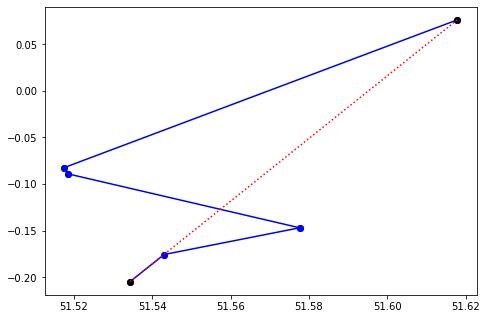

[51.53431265, 51.54303485, 51.57764662, 51.51843714, 51.51759826, 51.61785787]
[-0.204798149, -0.175626604, -0.146934862, -0.089017688, -0.082249622, 0.076179215]
['Queens Park', 'Swiss Cottage', 'Highgate', 'Moorgate', 'Liverpool Street', 'Chigwell']


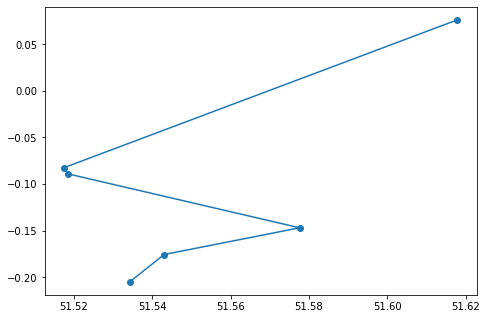

['Queens Park',
 'Swiss Cottage',
 'Highgate',
 'Moorgate',
 'Liverpool Street',
 'Chigwell']

In [106]:
import timeit

# ADD YOUR TEST CODE HERE

test = LondonRailwayMapper()

test.newRailwayLine(["Abbey Road", "Barbican", "Bethnal Green", "Cambridge Heath", "Covent Garden", "Dollis Hill", "East Finchley", "Finchley Road and Frognal", "Great Portland Street", "Hackney Wick", "Isleworth", "Kentish Town West", "Leyton", "Marble Arch", "North Wembley", "Old Street", "Pimlico", "Queens Park", "Richmond", "Shepherds Bush", "Tottenham Hale", "Uxbridge", "Vauxhall", "Wapping"])

The cell below exemplifies the test code I will invoke on your submission. Do NOT modify it. 


Execution time to load: 0.008
398
604
200
595
416
458
23
['North Wembley', 'Wembley Central', 'Euston', 'Warren Street', 'Oxford Circus', 'Regents Park', 'Baker Street']

Execution time minStops: 0.002
398
604
200
595
416
458
23
['North Wembley', 'Wembley Central', 'Euston', 'Warren Street', 'Oxford Circus', 'Regents Park', 'Baker Street']
Execution time minDistance: 0.002
From Baker Street to North Wembley in 6 stops and 6 miles
47
109
91
200
319
206
342
527
337
339
488
503
644
82
348
158
555
196
['Belsize Park', 'Chalk Farm', 'Camden Town', 'Euston', 'Kings Cross St. Pancras', 'Farringdon', 'Liverpool Street', 'Stratford', 'Leyton', 'Leytonstone', 'Snaresbrook', 'South Woodford', 'Woodford', 'Buckhurst Hill', 'Loughton', 'Debden', 'Theydon Bois', 'Epping']

Execution time minStops: 0.002
47
109
91
200
319
206
342
527
337
339
488
503
644
82
348
158
555
196
['Belsize Park', 'Chalk Farm', 'Camden Town', 'Euston', 'Kings Cross St. Pancras', 'Farringdon', 'Liverpool Street', 'Stratford',

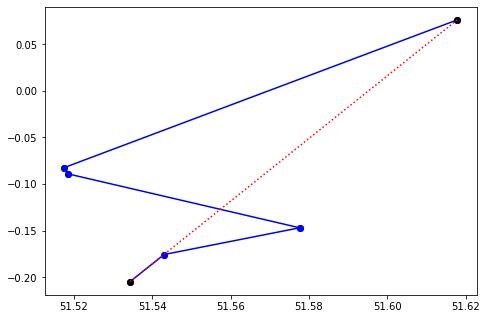

[51.53431265, 51.54303485, 51.57764662, 51.51843714, 51.51759826, 51.61785787, 51.53431265, 51.54303485, 51.57764662, 51.51843714, 51.51759826, 51.61785787]
[-0.204798149, -0.175626604, -0.146934862, -0.089017688, -0.082249622, 0.076179215, -0.204798149, -0.175626604, -0.146934862, -0.089017688, -0.082249622, 0.076179215]
['Queens Park', 'Swiss Cottage', 'Highgate', 'Moorgate', 'Liverpool Street', 'Chigwell', 'Queens Park', 'Swiss Cottage', 'Highgate', 'Moorgate', 'Liverpool Street', 'Chigwell']


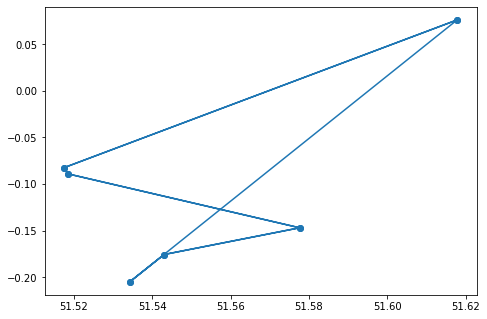



Station list ['Queens Park', 'Chigwell', 'Moorgate', 'Swiss Cottage', 'Liverpool Street', 'Highgate']
New station line ['Queens Park', 'Swiss Cottage', 'Highgate', 'Moorgate', 'Liverpool Street', 'Chigwell', 'Queens Park', 'Swiss Cottage', 'Highgate', 'Moorgate', 'Liverpool Street', 'Chigwell']
Total track length from Queens Park to Chigwell : 18.71004286299515 miles
Execution time newLine: 0.285
276
v: 3, w: 2, weight: 0.00519400251120033
0
v: 22, w: 16, weight: 0.010032790774089098
0
v: 15, w: 1, weight: 0.011435827089358452
0
v: 13, w: 8, weight: 0.017605209809025614
0
v: 8, w: 4, weight: 0.022363096694460998
1
v: 23, w: 2, weight: 0.022856226252789488
1
v: 11, w: 8, weight: 0.022930149590422378
1
v: 12, w: 9, weight: 0.023782730265400637
1
v: 16, w: 4, weight: 0.024750059954965948
1
v: 17, w: 7, weight: 0.026401701309755533
1
v: 22, w: 4, weight: 0.027032907118845345
2
v: 23, w: 3, weight: 0.027751925232079054
3
v: 4, w: 1, weight: 0.027803433667847953
3
v: 12, w: 0, weight: 0.02

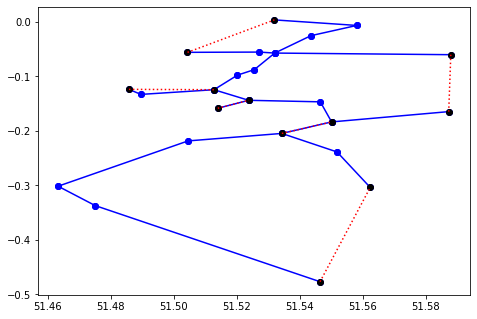

[51.53431265, 51.54303485, 51.57764662, 51.51843714, 51.51759826, 51.61785787, 51.53431265, 51.54303485, 51.57764662, 51.51843714, 51.51759826, 51.61785787, 51.53195199, 51.55813227, 51.54355841, 51.53205976, 51.52719174, 51.50434032, 51.52558147, 51.52021528, 51.51276023, 51.5237888, 51.51396549, 51.54654797, 51.5501195, 51.53431265, 51.50453215, 51.46323289, 51.47503742, 51.54645451, 51.56239629, 51.55185059, 51.58733254, 51.58799778, 51.48955286, 51.4857358]
[-0.204798149, -0.175626604, -0.146934862, -0.089017688, -0.082249622, 0.076179215, -0.204798149, -0.175626604, -0.146934862, -0.089017688, -0.082249622, 0.076179215, 0.003723371, -0.006465332, -0.025259503, -0.057203201, -0.055392112, -0.055860815, -0.087622958, -0.097721579, -0.124506895, -0.143961425, -0.158571216, -0.14675641, -0.183651203, -0.204798149, -0.218519159, -0.301739134, -0.337328765, -0.47710156, -0.303948219, -0.238797762, -0.164743886, -0.060187823, -0.133108258, -0.123829953]
['Queens Park', 'Swiss Cottage', '

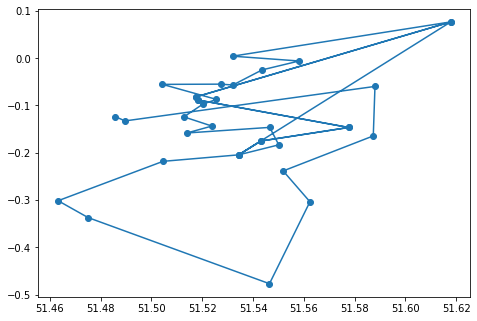



Station list ['Abbey Road', 'Barbican', 'Bethnal Green', 'Cambridge Heath', 'Covent Garden', 'Dollis Hill', 'East Finchley', 'Finchley Road and Frognal', 'Great Portland Street', 'Hackney Wick', 'Isleworth', 'Kentish Town West', 'Leyton', 'Marble Arch', 'North Wembley', 'Old Street', 'Pimlico', 'Queens Park', 'Richmond', 'Shepherds Bush', 'Tottenham Hale', 'Uxbridge', 'Vauxhall', 'Wapping']
New station line ['Queens Park', 'Swiss Cottage', 'Highgate', 'Moorgate', 'Liverpool Street', 'Chigwell', 'Queens Park', 'Swiss Cottage', 'Highgate', 'Moorgate', 'Liverpool Street', 'Chigwell', 'Abbey Road', 'Leyton', 'Hackney Wick', 'Cambridge Heath', 'Bethnal Green', 'Wapping', 'Old Street', 'Barbican', 'Covent Garden', 'Great Portland Street', 'Marble Arch', 'Kentish Town West', 'Finchley Road and Frognal', 'Queens Park', 'Shepherds Bush', 'Richmond', 'Isleworth', 'Uxbridge', 'North Wembley', 'Dollis Hill', 'East Finchley', 'Tottenham Hale', 'Pimlico', 'Vauxhall']
Total track length from Queens

In [107]:
# DO NOT MODIFY THIS CELL

import timeit

testMapper = LondonRailwayMapper()

#
# testing the loadStationsAndLines() API 
#
starttime = timeit.default_timer()
testMapper.loadStationsAndLines()
endtime = timeit.default_timer()
print("\nExecution time to load:", round(endtime-starttime,3))

#
# testing the minStops() and minStops() API on a sample of from/to station pairs  
#
fromList = ["Baker Street", "Epping", "Canonbury", "Vauxhall"]
toList = ["North Wembley", "Belsize Park", "Balham", "Leytonstone"]

for i in range(len(fromList)):
    starttime = timeit.default_timer()
    stops = testMapper.minStops(fromList[i], toList[i])
    endtime = timeit.default_timer()
    print("\nExecution time minStops:", round(endtime-starttime,3))

    starttime = timeit.default_timer()
    dist = testMapper.minStops(fromList[i], toList[i])
    endtime = timeit.default_timer()
    print("Execution time minDistance:", round(endtime-starttime,3))

    print("From", fromList[i], "to", toList[i], "in", stops, "stops and", dist, "miles")  
    
#
# testing the newRailwayLine() API on a small list of stations  
#
stationsList = ["Queens Park", "Chigwell", "Moorgate", "Swiss Cottage", "Liverpool Street", "Highgate"]

starttime = timeit.default_timer()
newLine = testMapper.newRailwayLine(stationsList)
endtime = timeit.default_timer()

print("\n\nStation list", stationsList)
print("New station line", newLine)
print("Total track length from", newLine[0], "to", newLine[len(newLine)-1], ":", testMapper.minDistance(newLine[0], newLine[len(newLine)-1]), "miles")
print("Execution time newLine:", round(endtime-starttime,3))

#
# testing the newRailwayLine() API on a big list of stations  
#
stationsList = ["Abbey Road", "Barbican", "Bethnal Green", "Cambridge Heath", "Covent Garden", "Dollis Hill", "East Finchley", "Finchley Road and Frognal", "Great Portland Street", "Hackney Wick", "Isleworth", "Kentish Town West", "Leyton", "Marble Arch", "North Wembley", "Old Street", "Pimlico", "Queens Park", "Richmond", "Shepherds Bush", "Tottenham Hale", "Uxbridge", "Vauxhall", "Wapping"]

starttime = timeit.default_timer()
newLine = testMapper.newRailwayLine(stationsList)
endtime = timeit.default_timer()

print("\n\nStation list", stationsList)
print("New station line", newLine)
print("Total track length from", newLine[0], "to", newLine[len(newLine)-1], ":", testMapper.minDistance(newLine[0], newLine[len(newLine)-1]), "miles")
print("Execution time newLine:", round(endtime-starttime,3))